In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from IPython.display import display

from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm

In [ ]:
df = pd.read_csv('train_all_inner.csv', index_col = 0)
print(df.shape)
df.head()

(144233, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
df['isFraud'].value_counts(dropna=False, normalize = True).values[0]

0.9215297470065796

# is_null proportion

In [ ]:
l_df_null = {}
for i in df.isnull().mean():
    l_df_null[round(i//0.05 * 0.05,2)] = l_df_null.get(round(i//0.05 * 0.05,2),0) + 1

pd.DataFrame(list(l_df_null.items()), columns=['Nan %', 'Count']).sort_values(by='Nan %')

,Nan %,Count
0,0.00,194
4,0.05,50
9,0.10,2
11,0.15,1
1,0.40,50
8,0.45,8
7,0.50,70
6,0.55,23
10,0.65,1
3,0.70,2


# Feature Selection based on Null% and Dominant%

In [ ]:
def threshold(t_null, t_dominant, df):
    many_null_col = list(set(
        [col for col in df.columns if df[col].isnull().mean() > t_null]))

    dominant_value_col =list(set(
        [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > t_dominant]))
    cols_to_drop = list(set(many_null_col+dominant_value_col))
    return cols_to_drop

In [ ]:
cols_to_drop=threshold(0.2, 0.8, df)
cols_to_drop.remove('isFraud')
df_drop = df.drop(columns=cols_to_drop)

print(df_drop.shape)
df_drop.head()

(144233, 83)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_19,id_20,id_28,id_29,id_31,id_35,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,542.0,144.0,New,NotFound,samsung browser 6.2,T,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,621.0,500.0,New,NotFound,mobile safari 11.0,T,F,T,mobile,iOS Device
2,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,...,410.0,142.0,Found,Found,chrome 62.0,F,T,T,desktop,Windows
3,2987011,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,...,176.0,507.0,New,NotFound,chrome 62.0,F,T,T,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,...,529.0,575.0,Found,Found,chrome 62.0,T,T,T,desktop,MacOS


In [ ]:
full_data_col = df_drop.loc[:, df_drop.isnull().sum() == 0].columns.values
categorical_col = df_drop.columns[df_drop.dtypes == 'object']
numerical_col = df_drop.columns[df_drop.dtypes != 'object']
categorical_col_NAN = [col for col in categorical_col if col not in full_data_col]
numerical_col_NAN = [col for col in numerical_col if col not in full_data_col]
num_full_col = [col for col in numerical_col if col in full_data_col]

# Correlation Check for Numerical Features

In [ ]:
corr_check ={}
for nan_col in numerical_col_NAN:
    corr_check[nan_col]={}
    for full_col in num_full_col[3:]:
        correlation = df_drop[nan_col].corr(df_drop[full_col])
        corr_check[nan_col][full_col] = correlation
avg_corr, max_feature, max_corr = [],[],[]
for i in corr_check.values():
    each_corr_value = list(i.values())
    each_corr_feature = list(i.keys())
    avg_corr.append(sum(each_corr_value)/len(each_corr_value))
    abs_corr = list(map(lambda x: abs(x), each_corr_value))
    max_abs_index = abs_corr.index(max(abs_corr))
    max_feature.append(each_corr_feature[max_abs_index])
    max_corr.append(each_corr_value[max_abs_index])

In [ ]:
df_corr_check = pd.DataFrame(list(zip(*[numerical_col_NAN, avg_corr, max_feature, max_corr])),
                             columns=['Nan_Feature', 'Avg_Corr', 'Max_NotNull_Feature', 'Max_Corr_Abs']).sort_values(by='Max_Corr_Abs')
df_corr_check = df_corr_check.reindex(df_corr_check['Max_Corr_Abs'].abs().sort_values(ascending=False).index)
df_corr_check.head()

,Nan_Feature,Avg_Corr,Max_NotNull_Feature,Max_Corr_Abs
48,id_17,0.014409,TransactionAmt,-0.334971
1,card3,0.023546,TransactionAmt,-0.256826
46,id_06,0.004944,id_01,0.201637
2,card5,-0.026465,card1,-0.199373
32,V263,0.012814,TransactionAmt,0.156411


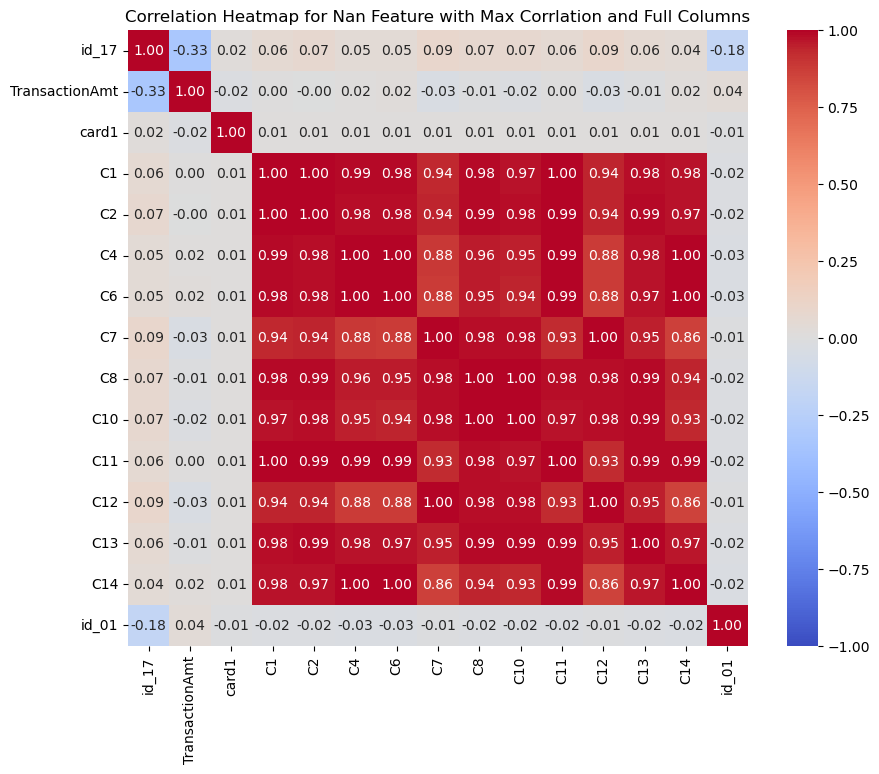

In [ ]:
corr_matrix = df_drop[["id_17"] + num_full_col[3:]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Nan Feature with Max Corrlation and Full Columns')
plt.show()

In [ ]:
df_test = df_drop.dropna(how='any')
1-df_test['isFraud'].mean()

0.9191162925340141

# Train/Test Split, Normalization, PCA

In [ ]:
X = df_test.sort_values('TransactionDT').drop((['isFraud', 'TransactionDT', 'TransactionID']+list(categorical_col)), axis=1)
y = list(df_test.sort_values('TransactionDT')['isFraud'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.fit_transform(X_test)

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_scaled_train)

X_pca_train = pca.transform(X_scaled_train)
X_pca_test = pca.transform(X_scaled_test)

# Isolation Forest

In [ ]:
IF = IsolationForest(n_estimators=200, contamination=0.08, n_jobs=-1, random_state=42).fit(X_train)
df_IF = pd.DataFrame(IF.decision_function(X_test), columns = ['Anomaly score'])
df_IF['predict'] = IF.predict(X_test)
df_IF['isFraud'] = y_test
df_IF

C:\Anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,Anomaly score,predict,isFraud
0,0.103453,1,0
1,0.122017,1,0
2,0.100507,1,0
3,0.153846,1,0
4,0.153612,1,0
...,...,...,...
15195,0.135413,1,0
15196,0.152204,1,0
15197,0.020098,1,0
15198,0.151268,1,0


In [ ]:
print(df_IF[df_IF['predict']==1]['isFraud'].value_counts(dropna=False, normalize = True))
print(df_IF[df_IF['predict']==-1]['isFraud'].value_counts(dropna=False, normalize = True))
print(df_IF['predict'].value_counts(dropna=False, normalize = True))

0    0.944001
1    0.055999
Name: isFraud, dtype: float64
0    0.626058
1    0.373942
Name: isFraud, dtype: float64
 1    0.922237
-1    0.077763
Name: predict, dtype: float64


In [ ]:
IF = IsolationForest(n_estimators=200, contamination=0.08, n_jobs=-1, random_state=42).fit(X_pca_train)
df_IF = pd.DataFrame(IF.decision_function(X_pca_test), columns = ['Anomaly score'])
df_IF['predict'] = IF.predict(X_pca_test)
df_IF['isFraud'] = y_test
df_IF

,Anomaly score,predict,isFraud
0,0.103504,1,0
1,0.087806,1,0
2,0.115398,1,0
3,0.171380,1,0
4,0.172769,1,0
...,...,...,...
15195,0.118588,1,0
15196,0.171940,1,0
15197,-0.118998,-1,0
15198,0.163847,1,0


In [ ]:
print(df_IF[df_IF['predict']==1]['isFraud'].value_counts(dropna=False, normalize = True))
print(df_IF[df_IF['predict']==-1]['isFraud'].value_counts(dropna=False, normalize = True))
print(df_IF['predict'].value_counts(dropna=False, normalize = True))

0    0.943821
1    0.056179
Name: isFraud, dtype: float64
0    0.635236
1    0.364764
Name: isFraud, dtype: float64
 1    0.920461
-1    0.079539
Name: predict, dtype: float64


# One Class SVM

In [ ]:
OC_SVM = svm.OneClassSVM().fit(X_scaled_train)

In [ ]:
df_OC_SVM = pd.DataFrame(
    OC_SVM.score_samples(
df_test[df_test['isFraud']==1].drop((['isFraud', 'TransactionDT', 'TransactionID']
                    +list(categorical_col)), axis=1),
    columns = ['Anomaly score'])
df_OC_SVM['predict'] = df_OC_SVM.predict(X_test)
df_IF['isFraud'] = y_test

In [ ]:
X = df_test.sort_values('TransactionDT').drop((['isFraud', 'TransactionDT', 'TransactionID']+list(categorical_col)), axis=1)
y = list(df_test.sort_values('TransactionDT')['isFraud'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
df_IF.sort_values(by='Anomaly score', ascending=True)

,Anomaly score,predict,isFraud
12819,-0.305974,-1,0.0
12636,-0.302264,-1,NaN
13023,-0.288457,-1,NaN
58062,-0.287476,-1,0.0
15161,-0.284981,-1,0.0
...,...,...,...
26235,0.164266,1,NaN
19525,0.164333,1,0.0
9256,0.164416,1,NaN
6462,0.164457,1,NaN


In [ ]:
df_IF[df_IF['isFraud']==1]['predict'].value_counts(dropna=False, normalize = True)

 1    0.924072
-1    0.075928
Name: predict, dtype: float64

In [ ]:
df_IF[df_IF['isFraud']==1]['predict']

In [ ]:
df_test['isFraud'].mean()

0.08088370746598594

In [ ]:
from sklearn.ensemble import IsolationForest
IF = IsolationForest(random_state=42).fit(X)


In [ ]:
charts = {}
for i in categorical_col_NAN:
    feature_count = df_drop[i].value_counts(dropna=False).reset_index().rename(columns={i: 'count', 'index': i})
    chart = alt.Chart(feature_count).mark_bar().encode(
                y=alt.Y(f"{i}:N", axis=alt.Axis(title=i)),
                x=alt.X('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']
            ).properties(title=f"Counts of {i}", width=400)
    charts[i] = chart

final_chart = ((charts['card4'] | charts['card6']) & (charts['P_emaildomain'] | charts['R_emaildomain']) & (charts['id_15'] | charts['id_16']) & (charts['id_28'] | charts['id_29']) & (charts['id_31'] | charts['id_35']) & (charts['id_37'] | charts['id_38']) & (charts['DeviceType'] | charts['DeviceInfo']))
display(final_chart)


alt.VConcatChart(...)

In [ ]:
l1 = list(num_full_col[3:])
high_corr_map = {}
new_numerical_col = numerical_col_NAN.copy()
for col in numerical_col_NAN:
    l2 = l1
    l2.append(col)
    data1 = df_drop.loc[:,l2]
    data1 = data1.dropna(how ='any')
    corr = data1.corr()
    abs_corr = corr.abs()
    # set diagonal value as 0
    for col in abs_corr:
        abs_corr.loc[col, col] = 0
    max_corr_value = abs_corr.max().max()
    if max_corr_value > 0.8:
        new_numerical_col.remove(col)
        high_corr_map[col] = max_corr_value
    max_corr_features = abs_corr.stack().idxmax()

KeyboardInterrupt: 